In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

In [2]:
def mase(y_true, y_pred, y_train):
    """
    Calculate MASE (Mean Absolute Scaled Error).
    y_true: Actual values
    y_pred: Predicted values
    y_train: Training data (used to calculate naive forecast errors)
    """
    # Calculate MAE of the forecast
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    
    # Calculate MAE of the naive forecast (shifted by one time step)
    mae_naive = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    
    # Calculate MASE
    mase_value = mae_forecast / mae_naive
    return mase_value

In [3]:
df = pd.read_csv("parkingLot.csv")

time_stamps = list(set(df["timestamp"].values)).sort()
camera_1 = df[df["camera_id"] == 1]
camera_2 = df[df["camera_id"] == 2]

ALL_time = df.groupby("timestamp").size()*0
print(type(ALL_time))
camera_1_count = camera_1.groupby("timestamp").size()
camera_2_count = camera_2.groupby("timestamp").size()

num_vehicle_enter = ALL_time.add(camera_1_count, fill_value=0).astype(int).reset_index(name="count")
num_vehicle_leave = ALL_time.add(camera_2_count, fill_value=0).astype(int).reset_index(name="count")

camera_1_count = camera_1.groupby("timestamp").size().reset_index(name="count")
camera_2_count = camera_2.groupby("timestamp").size().reset_index(name="count")
print(ALL_time[0:58])


<class 'pandas.core.series.Series'>
timestamp
2024-09-12 05:00:00    0
2024-09-12 05:20:00    0
2024-09-12 05:40:00    0
2024-09-12 06:00:00    0
2024-09-12 06:20:00    0
2024-09-12 06:40:00    0
2024-09-12 07:00:00    0
2024-09-12 07:20:00    0
2024-09-12 07:40:00    0
2024-09-12 08:00:00    0
2024-09-12 08:20:00    0
2024-09-12 08:40:00    0
2024-09-12 09:00:00    0
2024-09-12 09:20:00    0
2024-09-12 09:40:00    0
2024-09-12 10:00:00    0
2024-09-12 10:20:00    0
2024-09-12 10:40:00    0
2024-09-12 11:00:00    0
2024-09-12 11:20:00    0
2024-09-12 11:40:00    0
2024-09-12 12:00:00    0
2024-09-12 12:20:00    0
2024-09-12 12:40:00    0
2024-09-12 13:00:00    0
2024-09-12 13:20:00    0
2024-09-12 13:40:00    0
2024-09-12 14:00:00    0
2024-09-12 14:20:00    0
2024-09-12 14:40:00    0
2024-09-12 15:00:00    0
2024-09-12 15:20:00    0
2024-09-12 15:40:00    0
2024-09-12 16:00:00    0
2024-09-12 16:20:00    0
2024-09-12 16:40:00    0
2024-09-12 17:00:00    0
2024-09-12 17:20:00    0
2024

In [4]:
vehicles_entered = num_vehicle_enter["count"].values.reshape((-1,58)).sum(axis=1)
print(vehicles_entered)
vehicles_leave = num_vehicle_leave["count"].values.reshape((-1,58)).sum(axis=1)
print(vehicles_leave)

num_vehicle_enter["timestamp"] = pd.to_datetime(num_vehicle_enter["timestamp"])
time_hr = num_vehicle_enter["timestamp"].dt.time
min_arr = pd.to_timedelta(time_hr.astype(str)).dt.total_seconds() // 60
min_arr = min_arr.values[0:58]
min_arr[-1] = 1440

print(num_vehicle_enter)
total_time_entered = (num_vehicle_enter["count"].values.reshape(-1,58)*min_arr).sum(axis=1)
total_time_left = (num_vehicle_leave["count"].values.reshape(-1,58)*min_arr).sum(axis=1)

avgtime_spent = (total_time_left-total_time_entered)/vehicles_entered
print(vehicles_entered)
print(avgtime_spent)

[ 886  809  925 1073  843  803  940  902  789  919  859  829  831  734
  755  784  827  905  803  733  993  843  821  803  855  863  749  869
  821  800  851  996  856  823  895  785  829  771  808  868  860  857
  850  799  799  844  829  879  867  753  908  864  847  893  878  902
  807  798  906  944  828  806  781]
[ 886  809  925 1073  843  803  940  902  789  919  859  829  831  734
  755  784  827  905  803  733  993  843  821  803  855  863  749  869
  821  800  851  996  856  823  895  785  829  771  808  868  860  857
  850  799  799  844  829  879  867  753  908  864  847  893  878  902
  807  798  906  944  828  806  781]
               timestamp  count
0    2024-09-12 05:00:00     22
1    2024-09-12 05:20:00     19
2    2024-09-12 05:40:00     13
3    2024-09-12 06:00:00     23
4    2024-09-12 06:20:00     22
...                  ...    ...
3649 2024-11-13 22:40:00      0
3650 2024-11-13 23:00:00      0
3651 2024-11-13 23:20:00      0
3652 2024-11-13 23:40:00      0
3653 2

<Figure size 1200x600 with 0 Axes>

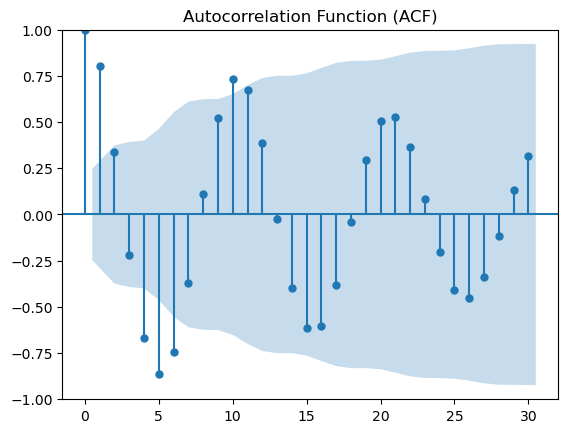

<Figure size 1200x600 with 0 Axes>

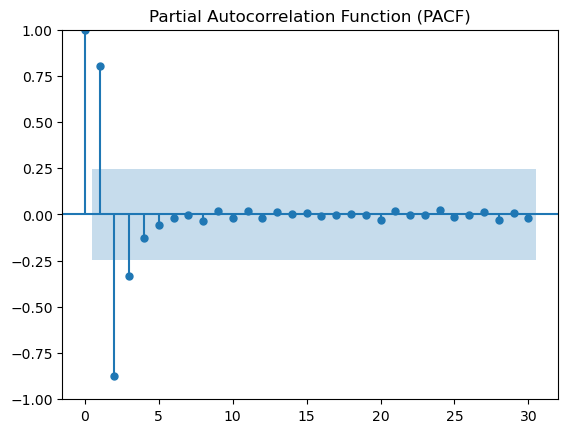

In [5]:
plt.figure(figsize=(12, 6))
plot_acf(avgtime_spent, lags=30)  
plt.title("Autocorrelation Function (ACF)")
plt.show()


plt.figure(figsize=(12, 6))
plot_pacf(avgtime_spent, lags=30)  
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

In [6]:
auto_model_avg = ARIMA(avgtime_spent[:-7], order=(2,0,3))  # (p, d, q)
model_fit = auto_model_avg.fit()


forecast_next_14_avg_time_spent = model_fit.forecast(steps=14)
print(forecast_next_14_avg_time_spent)

[369.01312975 341.47005938 308.83728228 282.86546125 272.84206133
 282.32040062 307.86017743 340.27598124 367.94076351 380.95622327
 374.6942957  351.44266731 319.56930375 290.51100432]


/Users/kamyak/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Forecast on average time spent for next 7 days: [340.27598124 367.94076351 380.95622327 374.6942957  351.44266731
 319.56930375 290.51100432]
Mean absolute scaled error is:  0.0837135968709979
Mean absolute percentage error is:  1.3170246387615727


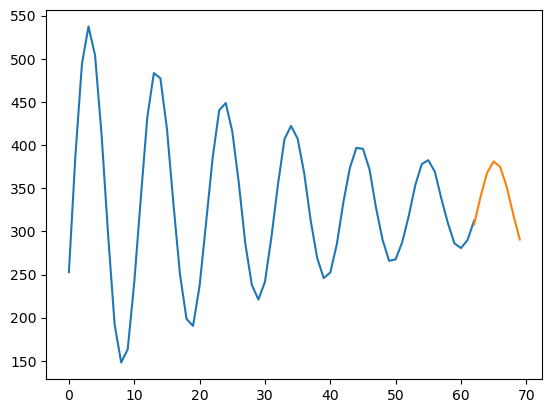

In [7]:
mse = mean_squared_error(avgtime_spent[-7:], forecast_next_14_avg_time_spent[-14:-7])

print("ARIMA Forecast on average time spent for next 7 days:", forecast_next_14_avg_time_spent[-7:])

mean_absolute_scaled_error = mase(avgtime_spent[-7:],forecast_next_14_avg_time_spent[-14:-7],avgtime_spent[:-7])
print("Mean absolute scaled error is: ",mean_absolute_scaled_error)

mean_abs_percentage_error = mean_absolute_percentage_error(avgtime_spent[-7:],forecast_next_14_avg_time_spent[-14:-7])*100
print("Mean absolute percentage error is: ",mean_abs_percentage_error)

plt.plot(avgtime_spent)
indices = range(len(avgtime_spent)-1,len(avgtime_spent)+7)
plt.plot(indices,forecast_next_14_avg_time_spent[6:])


plt.show()